In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import datetime
import time
import warnings
from sklearn.model_selection import train_test_split
from model import *
from rgf.sklearn import RGFClassifier
import xgbfir
from sklearn.preprocessing import minmax_scale
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm  import LGBMClassifier

In [2]:
%load_ext autoreload
%autoreload 2
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
# 关闭 SettingWithCopyWarning 
pd.set_option('mode.chained_assignment', None)

In [3]:
df = pd.read_csv('data.csv', encoding='gbk')

In [4]:
df.shape

(4754, 90)

In [5]:
df.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


In [6]:
x = df.drop('status', axis=1)
y = df['status']

# 数据类型分析

In [7]:
train_test = x

In [8]:
train_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Columns: 89 entries, Unnamed: 0 to loans_latest_day
dtypes: float64(70), int64(12), object(7)
memory usage: 3.2+ MB


原数据中数值型特征有 82 个，字符串类型特征有 7 个，多数特征缺失值不是特别多，student_feature 缺失值较多。

In [9]:
train_test.describe()

,Unnamed: 0,custid,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
count,4754.000000,4.754000e+03,4752.000000,4752.000000,4754.000000,4751.000000,4752.000000,4752.000000,4752.000000,4746.000000,...,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4457.000000,4450.000000,4457.000000
mean,6008.414178,1.690993e+06,0.021806,0.901294,1940.197728,14.160674,0.804411,0.365425,17.502946,29.029920,...,3390.038142,1820.357864,9187.009199,76.042630,4.732331,5.227507,16153.690823,8007.696881,24.112809,55.181512
std,3452.071428,1.034235e+06,0.041527,0.144856,3923.971494,694.180473,0.196920,0.170196,4.475616,22.722432,...,1474.206546,583.418291,7371.257043,14.536819,2.974596,3.409292,14301.037628,5679.418585,37.725724,53.486408
min,5.000000,1.140000e+02,0.000000,0.000000,0.000000,0.000000,0.120000,0.033000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000
25%,3106.000000,7.593358e+05,0.010000,0.880000,0.000000,0.615000,0.670000,0.233000,15.000000,16.000000,...,2300.000000,1535.000000,4800.000000,77.000000,2.000000,3.000000,7800.000000,4737.000000,5.000000,10.000000
50%,6006.500000,1.634942e+06,0.010000,0.960000,500.000000,0.970000,0.860000,0.350000,17.000000,23.000000,...,3100.000000,1810.000000,7700.000000,79.000000,4.000000,5.000000,13800.000000,7050.000000,14.000000,36.000000
75%,8999.000000,2.597905e+06,0.020000,0.990000,2000.000000,1.600000,1.000000,0.480000,20.000000,32.000000,...,4300.000000,2100.000000,11700.000000,80.000000,7.000000,7.000000,20400.000000,10000.000000,24.000000,91.000000
max,11992.000000,4.004694e+06,1.000000,1.000000,68000.000000,47596.740000,1.000000,0.941000,42.000000,285.000000,...,10000.000000,6900.000000,87100.000000,87.000000,18.000000,20.000000,266400.000000,82800.000000,360.000000,323.000000


In [10]:
train_test.describe(include='O')

,trade_no,bank_card_no,reg_preference_for_trad,source,id_name,latest_query_time,loans_latest_time
count,4754,4754,4752,4754,4478,4450,4457
unique,4754,1,5,1,4309,207,232
top,20180507114850886000000388190426,卡号1,一线城市,xs,李杰,2018-04-14,2018-05-03
freq,1,4754,3403,4754,5,423,134


In [11]:
y.mean()

0.2509465713083719

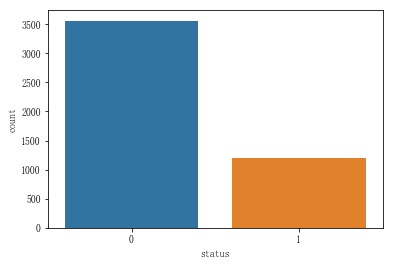

In [12]:
sns.countplot(y)

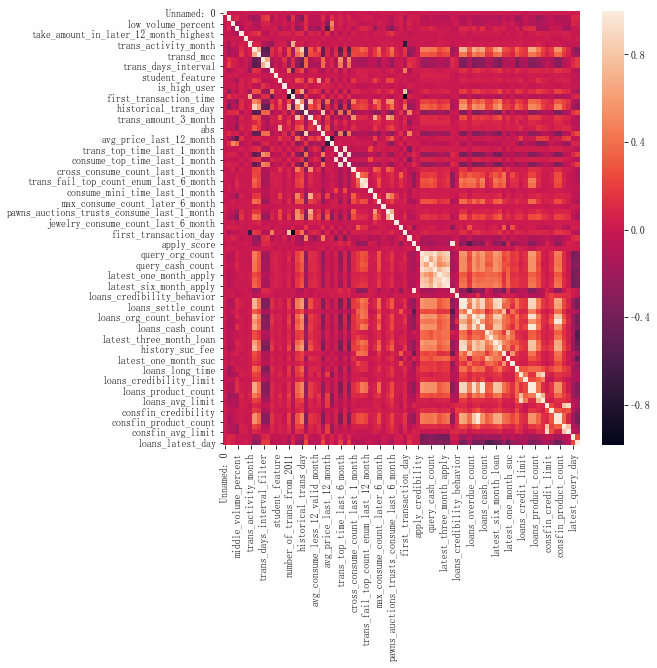

In [13]:
corr_mat = df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_mat)

相关性较强的特征集中在关于下半部分

# 原数据简单处理的结果

In [14]:
dataset01 = train_test.drop(["custid","trade_no","bank_card_no","id_name","first_transaction_time","latest_query_time","loans_latest_time","source"],axis=1)

In [15]:
# 用众数填充缺失值
for c in dataset01.columns:
    dataset01.loc[dataset01[c].isnull(), c] = dataset01[c].mode()[0]

In [16]:
city_map = {'一线城市':1, '二线城市':2, '三线城市':3, '其他城市':4, '境外':0}
dataset01['reg_preference_for_trad'] = dataset01['reg_preference_for_trad'].map(city_map)
dataset01["student_feature"] = dataset01["student_feature"].replace([2],[0])

In [17]:
dataset01 = dataset01.convert_objects(convert_numeric=True)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [18]:
def print_result(model, x_train, y_train, x_test):
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_train_proba = model.predict_proba(x_train)[:, 1]
    print('----Training Report----')
    model.report(y_train, y_train_pred, y_train_proba)
    print('----Test Report----')
    y_test_pred = model.predict(x_test)
    y_test_proba = model.predict_proba(x_test)[:, 1]
    model.report(y_test, y_test_pred, y_test_proba)

In [19]:
x_train, x_test, y_train, y_test = train_test_split(dataset01, y, test_size=0.2, random_state=666)
x_train_scale = minmax_scale(x_train)
x_test_scale = minmax_scale(x_test)

In [20]:
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train_scale, y_train, x_test_scale)

----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.98      0.88      2863
          1       0.82      0.22      0.35       940

avg / total       0.80      0.80      0.75      3803

SVC AUC：
 0.8076181062863682
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.76      0.99      0.86       698
          1       0.80      0.16      0.26       253

avg / total       0.77      0.77      0.70       951

SVC AUC：
 0.7789335991030273


In [21]:
xgbClassifier = XGBClassifier()
xgbmodel = SklearnWrapper(xgbClassifier)
print_result(xgbmodel, x_train, y_train, x_test)

----Training Report----
XGBClassifier report：
              precision    recall  f1-score   support

          0       0.85      0.98      0.91      2863
          1       0.86      0.47      0.61       940

avg / total       0.85      0.85      0.83      3803

XGBClassifier AUC：
 0.9034508512867769
----Test Report----
XGBClassifier report：
              precision    recall  f1-score   support

          0       0.80      0.95      0.87       698
          1       0.69      0.34      0.46       253

avg / total       0.77      0.78      0.76       951

XGBClassifier AUC：
 0.7894775586939533


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 无关特征删除

## 类别特征

### bank_card_no 和 source

bank_card_no 和 source unique 等于 1，删除

In [22]:
train_test.drop(['bank_card_no', 'source'], axis=1, inplace=True)

### trade_no

In [23]:
train_test['trade_no'].head(10)

0    20180507115231274000000023057383
1    20180507121002192000000023073000
2    20180507125159718000000023114911
3    20180507121358683000000388283484
4    20180507115448545000000388205844
5    20180507121233054000000388275132
6    20180507121931540000000388298915
7    20180507124659235000000023105807
8    20180507115855621000000388224458
9    20180504155156296000000021138084
Name: trade_no, dtype: object

In [24]:
def parse_trade_no(array):
    lst = [array[:4], array[4:6], array[6:8], array[-10:]]
    return lst

In [25]:
tradeno_df = pd.DataFrame(train_test['trade_no'].apply(parse_trade_no).values.tolist(), columns=['tradeno_year', 'tradeno_month', 'tradeno_day', 'tradeno_id'])

In [26]:
tradeno_df.describe()

,tradeno_year,tradeno_month,tradeno_day,tradeno_id
count,4754,4754,4754,4754
unique,1,1,3,4754
top,2018,05,07,0388214895
freq,4754,4754,3682,1


In [27]:
tradeno_df['tradeno_day'].value_counts()

07    3682
04    1062
08      10
Name: tradeno_day, dtype: int64

trade_no 字段像个 id 字段，假设前 8 位是年月日信息，可以看出 trade_no 均是在 2018 年 5 月份，tradeno_id 各不相同，保留 tradeno_day，其他的信息删除。

In [28]:
train_test = pd.concat((train_test.drop('trade_no', axis=1), tradeno_df['tradeno_day']), axis=1)

In [29]:
train_test['tradeno_day'].value_counts()

07    3682
04    1062
08      10
Name: tradeno_day, dtype: int64

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


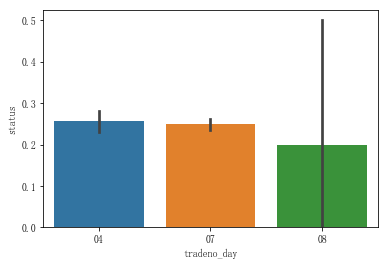

In [30]:
sns.barplot(data=pd.concat((train_test.loc[:x.shape[0]], y), axis=1), x='tradeno_day', y='status')

### id_name

找出出现次数比较多的人名，看看逾期率

In [31]:
idname_count=train_test['id_name'].value_counts()
idname_count = idname_count[idname_count>=4]
idn_df = train_test[train_test['id_name'].isin(idname_count.index)]

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


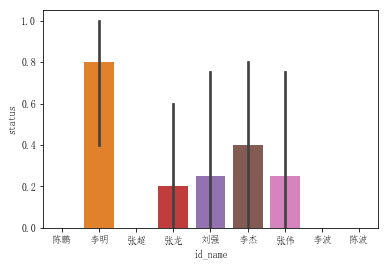

In [32]:
sns.barplot(data=pd.concat((idn_df, y), axis=1), x='id_name', y='status')

李明这个人逾期率挺高的，重点提出来作为类别变量

In [33]:
train_test['is_Li_Ming'] = (df['id_name'] == '李明').apply(int)
train_test.drop('id_name', inplace=True, axis=1)

## 数值特征

In [34]:
value_cols = train_test.describe().columns

In [35]:
train_test[value_cols].nunique().describe()

count      83.000000
mean      486.650602
std      1051.987056
min         2.000000
25%        25.000000
50%        65.000000
75%       222.500000
max      4754.000000
dtype: float64

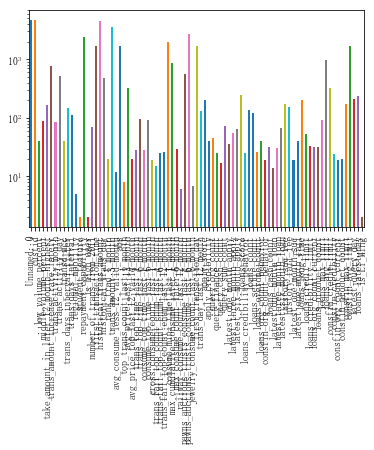

In [36]:
train_test[value_cols].nunique().plot(kind='bar', logy=True)

In [37]:
print('数值特征 unique < 10 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<10]))
print('数值特征 unique < 20 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<20]))
print('数值特征 unique < 30 个数：', len(train_test[value_cols].columns[train_test[value_cols].nunique()<30]))

数值特征 unique < 10 个数： 7
数值特征 unique < 20 个数： 15
数值特征 unique < 30 个数： 27


In [38]:
print('全部为 unique 的特征', train_test[value_cols].columns[train_test[value_cols].nunique()==len(train_test)])

全部为 unique 的特征 Index(['Unnamed: 0', 'custid'], dtype='object')


从 unique 数量来讲，没有 unique == 1 的情况，先不予删除。

### custid

custid 范围中 100~400W，如果假设注册越早，id 越小，看一下 id 大小与逾期率的关系。

In [39]:
custid_range = [1, 1e4, 1e5, 1e6, 2.5e6, 5e6]

In [40]:
train_test['cust_id_bin'] = pd.cut(train_test['custid'], bins=custid_range, labels=[str(i) for i in custid_range][:-1]).astype('float')
train_test.drop('custid', axis=1, inplace=True)

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


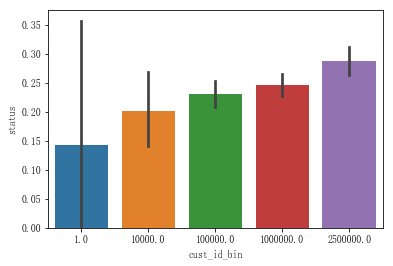

In [41]:
sns.barplot(data=pd.concat((train_test, y),axis=1), x='cust_id_bin', y='status')

正如猜想的一样，id 越小，逾期率越低，可能原因是越最近注册的，是新用户，紧急用钱，越可能逾期。先保留 id 这个特征。

### Unnamed: 0

In [42]:
sum(train_test['Unnamed: 0'].diff(1)>0)

4753

In [43]:
len(train_test)

4754

Unnamed: 0 这个特征数值是递增的，删除

In [44]:
train_test.drop('Unnamed: 0', axis=1, inplace=True)

In [45]:
train_test.describe(include='O')

,reg_preference_for_trad,latest_query_time,loans_latest_time,tradeno_day
count,4752,4450,4457,4754
unique,5,207,232,3
top,一线城市,2018-04-14,2018-05-03,07
freq,3403,423,134,3682


In [46]:
dataset02 = train_test.drop(["latest_query_time","loans_latest_time"], axis=1)
# 用众数填充缺失值
for c in dataset02.columns:
    dataset02.loc[dataset02[c].isnull(), c] = dataset02[c].mode()[0]
dataset02["student_feature"] = dataset02["student_feature"].replace([2],[0])
dataset02['reg_preference_for_trad'] = dataset02['reg_preference_for_trad'].map(city_map)
dataset02 = dataset02.convert_objects(convert_numeric=True)
dataset02 = minmax_scale(dataset02)
x_train, x_test, y_train, y_test = train_test_split(dataset02, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  import sys


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.99      0.88      2863
          1       0.82      0.20      0.33       940

avg / total       0.80      0.79      0.74      3803

SVC AUC：
 0.809300057223118
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.98      0.86       698
          1       0.78      0.19      0.31       253

avg / total       0.77      0.77      0.72       951

SVC AUC：
 0.7988748202090671


# 数据类型转换

In [47]:
train_test.describe(include='O')

,reg_preference_for_trad,latest_query_time,loans_latest_time,tradeno_day
count,4752,4450,4457,4754
unique,5,207,232,3
top,一线城市,2018-04-14,2018-05-03,07
freq,3403,423,134,3682


## reg_preference_for_trad

In [48]:
train_test['reg_preference_for_trad'].value_counts()

一线城市    3403
三线城市    1064
境外       150
二线城市     131
其他城市       4
Name: reg_preference_for_trad, dtype: int64

城市之间存在大小差别，采用自然数编码

In [49]:
city_map = {'一线城市':1, '二线城市':2, '三线城市':3, '其他城市':0, '境外':5}

In [50]:
train_test['reg_preference_for_trad'] = train_test['reg_preference_for_trad'].map(city_map)

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


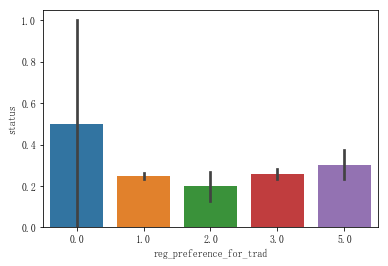

In [51]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='reg_preference_for_trad', y='status')

## tradeno_day

In [52]:
train_test['tradeno_day'] = train_test['tradeno_day'].astype('int')

In [53]:
train_test.describe(include='O')

,latest_query_time,loans_latest_time
count,4450,4457
unique,207,232
top,2018-04-14,2018-05-03
freq,423,134


# 处理数值特征

对于数值特征会出现一些较大和较小的异常值，采用分位数处理。

In [54]:
featnames = [i for i in train_test.columns if train_test[i].dtype in [np.int64, np.float]]

In [55]:
for i in featnames:
    train_test[i][train_test[i] > np.percentile(
        train_test[i][train_test[i].notnull()], 99.9)] = np.percentile(train_test[i], 99.9)
    train_test[i][train_test[i] < np.percentile(
        train_test[i][train_test[i].notnull()], 0.1)] = np.percentile(train_test[i], 0.01)

C:\Users\hotheat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\hotheat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\hotheat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\hotheat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\hotheat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\hotheat\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\h

In [56]:
train_test.describe()

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,tradeno_day,is_Li_Ming,cust_id_bin
count,4747.000000,4752.000000,4754.000000,4746.000000,4751.000000,4747.000000,4748.000000,4741.000000,4746.000000,4752.000000,...,4457.000000,4453.000000,4452.000000,4452.000000,4452.000000,4445.000000,4452.000000,4754.000000,4754.000000,4.754000e+03
mean,0.020906,0.901294,1930.380522,2.654305,0.804555,0.364843,17.482940,28.794558,21.579225,2.678662,...,76.042630,4.721536,5.212264,15959.973046,7944.902291,23.741732,54.899596,6.331931,0.000260,1.114260e+06
std,0.030526,0.144856,3802.629884,10.797259,0.196691,0.169337,4.424057,21.535693,15.527403,0.890360,...,14.536819,2.953925,3.380545,12989.166694,5349.571347,36.086422,52.849073,1.251653,0.008007,9.235152e+05
min,0.000000,0.000000,0.000000,0.000000,0.140000,0.033000,2.000000,0.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-2.000000,-2.000000,4.000000,0.000000,1.000000e+00
25%,0.010000,0.880000,0.000000,0.610000,0.670000,0.233000,15.000000,16.000000,12.000000,2.000000,...,77.000000,2.000000,3.000000,7800.000000,4736.000000,5.000000,10.000000,7.000000,0.000000,1.000000e+05
50%,0.010000,0.960000,500.000000,0.970000,0.860000,0.350000,17.000000,23.000000,17.000000,3.000000,...,79.000000,4.000000,5.000000,13800.000000,7044.500000,14.000000,36.000000,7.000000,0.000000,1.000000e+06
75%,0.020000,0.990000,2000.000000,1.590000,1.000000,0.477000,20.000000,32.000000,26.000000,3.000000,...,80.000000,7.000000,7.000000,20400.000000,9981.250000,24.000000,90.000000,7.000000,0.000000,2.500000e+06
max,0.520000,1.000000,38345.800000,308.300000,1.000000,0.888000,40.000000,205.000000,150.000000,5.000000,...,87.000000,15.000000,17.000000,135600.000000,50400.000000,348.000000,291.000000,8.000000,0.247000,2.500000e+06


# 缺失值处理

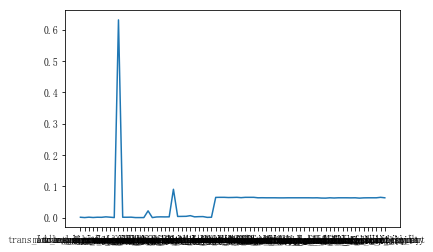

In [57]:
nan_prop = train_test.isnull().sum(axis=0)[train_test.isnull().sum(axis=0)!=0]/train_test.shape[0]
plt.plot(nan_prop)

## 缺失值处理

缺失值大概分成三类，比例在 60%，5%~10%, 1% 左右

### 缺失比例>10%

只有一列，转换成 one-hot 编码

In [58]:
nan100 = train_test[train_test.columns[train_test.isnull().sum(0)/train_test.shape[0]>0.1]]

In [59]:
nan100['student_feature'].value_counts()

1.0    1754
Name: student_feature, dtype: int64

In [60]:
def parse_student_feature(array):
    lst = [0, 0]
    if array == 1:
        lst[0] = 1
    elif array == 2:
        lst[1] = 1
    return lst

In [61]:
stu_featdf = pd.DataFrame(train_test['student_feature'].apply(parse_student_feature).values.tolist(
), columns=['student_feat_1', 'student_feat_2'])

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


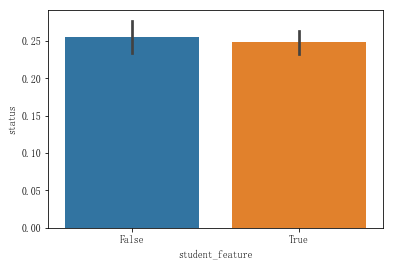

In [62]:
sns.barplot(data=pd.concat((train_test['student_feature'].isnull(), y), axis=1), x='student_feature', y='status')

student 是否缺失与逾期率相差不大

In [63]:
train_test = pd.concat((train_test.drop('student_feature', axis=1), stu_featdf), axis=1)

In [64]:
# 用众数填充剩下的缺失值
for c in train_test.columns:
    train_test.loc[train_test[c].isnull(), c] = train_test[c].mode()[0]

In [65]:
dataset03 = train_test.drop(["latest_query_time","loans_latest_time"], axis=1)

dataset03 = dataset03.convert_objects(convert_numeric=True)
dataset03 = minmax_scale(dataset03)
x_train, x_test, y_train, y_test = train_test_split(dataset03, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.79      0.98      0.88      2863
          1       0.81      0.23      0.36       940

avg / total       0.80      0.80      0.75      3803

SVC AUC：
 0.8061596599311835
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.98      0.86       698
          1       0.77      0.21      0.33       253

avg / total       0.77      0.77      0.72       951

SVC AUC：
 0.7951629160673636


## 时间特征

In [66]:
time_feat = train_test[['latest_query_time', 'loans_latest_time']]

In [67]:
train_test['latest_query_time_year'] = pd.to_datetime(train_test['latest_query_time']).dt.year
train_test['latest_query_time_month'] = pd.to_datetime(train_test['latest_query_time']).dt.month
train_test['latest_query_time_dayofyear'] = pd.to_datetime(train_test['latest_query_time']).dt.dayofyear
train_test['latest_query_time_dayofweek'] = pd.to_datetime(train_test['latest_query_time']).dt.dayofweek
train_test['latest_query_time_weekday'] =(train_test['latest_query_time_dayofweek']<=5).apply(int)

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


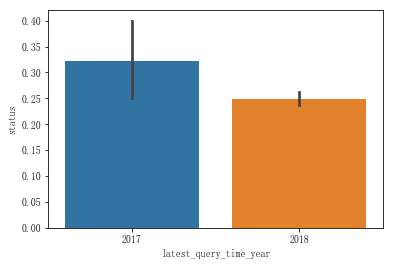

In [68]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_year'], y), axis=1), x='latest_query_time_year', y='status')

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


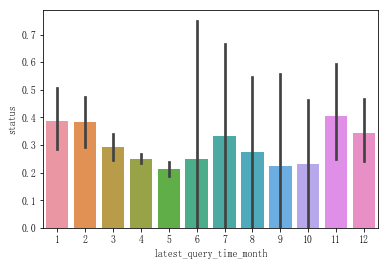

In [69]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_month'], y), axis=1), x='latest_query_time_month', y='status')

In [70]:
train_test['loans_latest_time_year'] = pd.to_datetime(train_test['loans_latest_time']).dt.year
train_test['loans_latest_time_month'] = pd.to_datetime(train_test['loans_latest_time']).dt.month
train_test['loans_latest_time_dayofyear'] = pd.to_datetime(train_test['loans_latest_time']).dt.dayofyear
train_test['loans_latest_time_dayofweek'] = pd.to_datetime(train_test['loans_latest_time']).dt.dayofweek
train_test['loans_latest_time_weekday'] =(train_test['loans_latest_time_dayofweek']<=5).apply(int)

In [71]:
train_test['interval_query_loan_time'] = pd.to_datetime(
    train_test['latest_query_time'])-pd.to_datetime(train_test['loans_latest_time'])
train_test['interval_query_loan_time'] = train_test['interval_query_loan_time'].apply(lambda x:x.days)

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


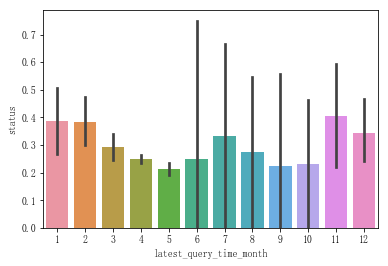

In [72]:
sns.barplot(data=pd.concat(
    (train_test['latest_query_time_month'], y), axis=1), x='latest_query_time_month', y='status')

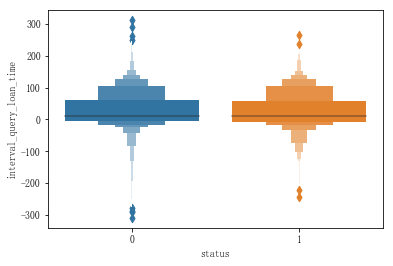

In [73]:
sns.boxenplot(data=pd.concat(
    (train_test['interval_query_loan_time'], y), axis=1), y='interval_query_loan_time', x='status')

In [74]:
train_test.drop(['loans_latest_time', 'latest_query_time'], axis=1, inplace=True)

In [75]:
dataset04 = train_test

dataset04 = dataset04.convert_objects(convert_numeric=True)
dataset04 = minmax_scale(dataset04)
x_train, x_test, y_train, y_test = train_test_split(dataset04, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.80      0.98      0.88      2863
          1       0.81      0.24      0.36       940

avg / total       0.80      0.80      0.75      3803

SVC AUC：
 0.8059922637316905
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.77      0.97      0.86       698
          1       0.74      0.21      0.33       253

avg / total       0.76      0.77      0.72       951

SVC AUC：
 0.7957518375482745


# 特征工程

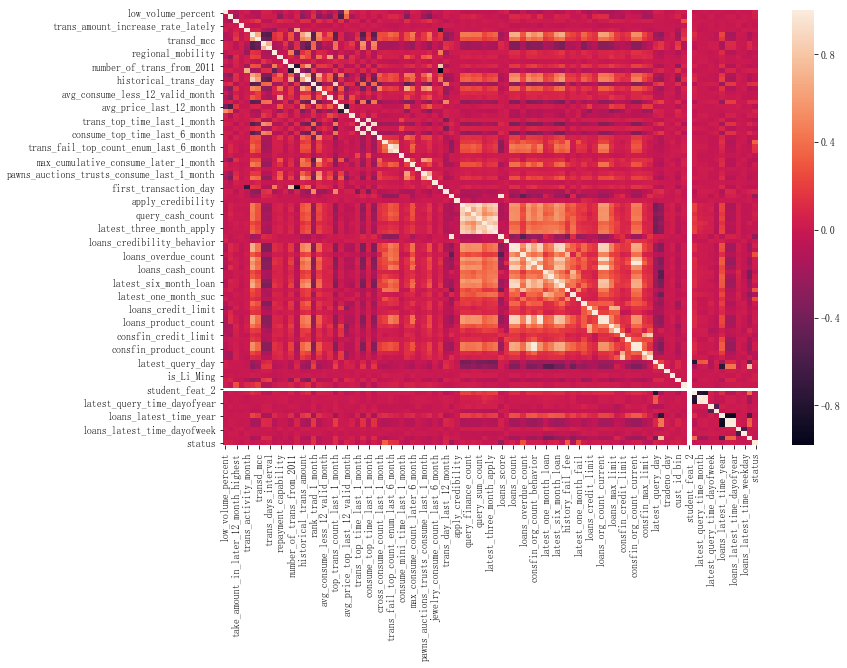

In [76]:
corr_mat = pd.concat((train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

In [77]:
corr_mat.loc['status'].sort_values(ascending=False)

status                                        1.000000
trans_fail_top_count_enum_last_1_month        0.334393
history_fail_fee                              0.305322
loans_overdue_count                           0.266905
latest_one_month_fail                         0.254929
trans_fail_top_count_enum_last_6_month        0.156268
rank_trad_1_month                             0.146643
trans_fail_top_count_enum_last_12_month       0.137621
top_trans_count_last_1_month                  0.117299
trans_day_last_12_month                       0.089644
avg_price_top_last_12_valid_month             0.071259
latest_query_day                              0.061290
latest_six_month_loan                         0.059099
low_volume_percent                            0.056441
query_cash_count                              0.055373
cust_id_bin                                   0.054846
loans_count                                   0.048382
latest_three_month_loan                       0.041476
is_Li_Ming

## 相关性强的特征

### 类别特征

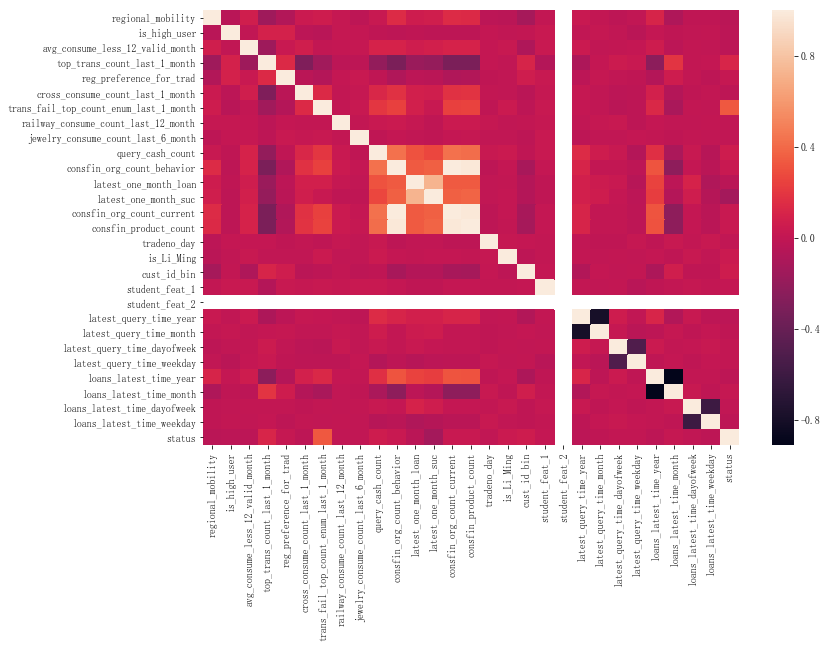

In [78]:
# nunique 小于 20 的 相关性系数
cat_cols = train_test.nunique()[train_test.nunique()<20].index
cat_train_test = train_test[cat_cols]
corr_mat = pd.concat((cat_train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

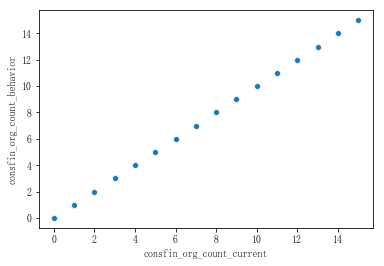

In [79]:
sns.scatterplot(train_test['consfin_org_count_current'], train_test['consfin_org_count_behavior'])

consfin_org_count_current 和 consfin_org_count_behavior 相关性系数非常高，数据相同，删除一个特征，  
并没有发现与 status 相关系数特别高的类别特征

In [80]:
train_test.drop('consfin_org_count_current', axis=1, inplace=True)

### 数值特征

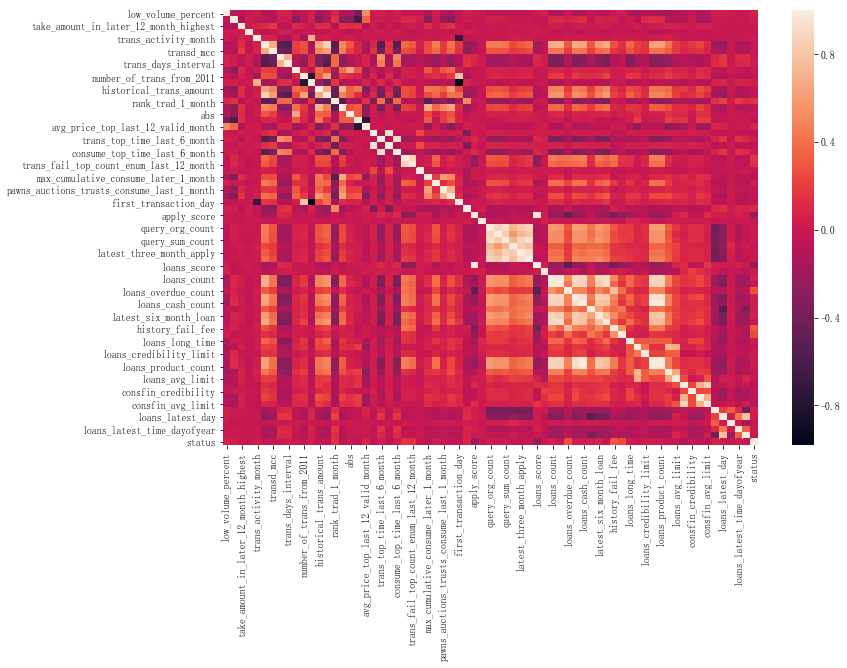

In [81]:
# nunique 大于 20 的 相关性系数
cat_cols = train_test.nunique()[train_test.nunique()>=20].index
cat_train_test = train_test[cat_cols]
corr_mat = pd.concat((cat_train_test, y), axis=1).corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat)

In [82]:
high_corrs = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.9 or corr_mat.values[i][j] <-0.9:
            if i != j:
                high_corrs.append((corr_mat.index[i], corr_mat.columns[j]))

In [83]:
high_corrs

[('first_transaction_time', 'first_transaction_day'),
 ('trans_top_time_last_1_month', 'consume_top_time_last_1_month'),
 ('trans_top_time_last_6_month', 'consume_top_time_last_6_month'),
 ('apply_score', 'loans_score'),
 ('query_org_count', 'query_sum_count'),
 ('query_sum_count', 'latest_six_month_apply'),
 ('latest_three_month_apply', 'latest_six_month_apply'),
 ('loans_count', 'loans_settle_count'),
 ('loans_count', 'loans_org_count_behavior'),
 ('loans_count', 'history_suc_fee'),
 ('loans_settle_count', 'history_suc_fee'),
 ('loans_org_count_behavior', 'loans_cash_count'),
 ('loans_org_count_behavior', 'loans_org_count_current'),
 ('loans_org_count_behavior', 'loans_product_count'),
 ('loans_cash_count', 'loans_org_count_current'),
 ('loans_cash_count', 'loans_product_count'),
 ('loans_org_count_current', 'loans_product_count')]

上述特征之间的相关系数大于 0.9

In [84]:
def scatter_corr(idx, ax):
    c1, c2 = high_corrs[idx]
    sns.scatterplot(train_test[c1], train_test[c2], ax=ax)

In [85]:
len(high_corrs)

17

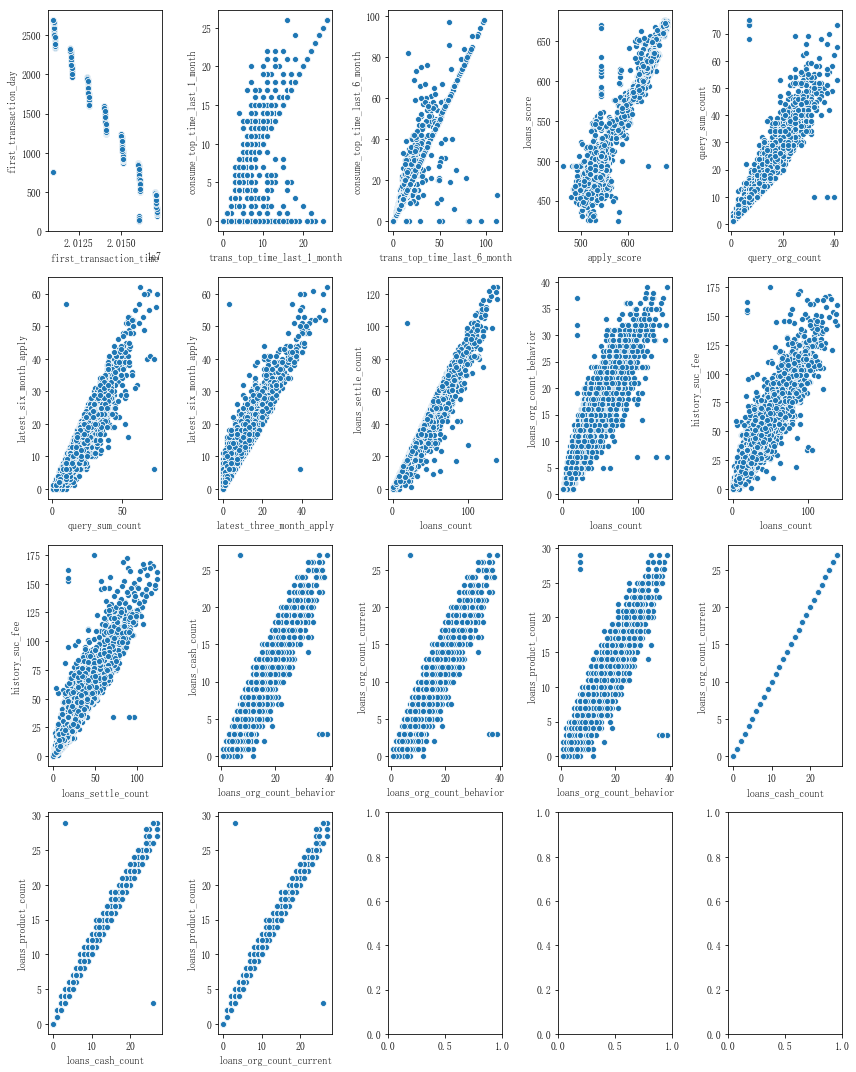

In [86]:
fig, axes = plt.subplots(4, 5, figsize=(12, 15))
axes = [j for i in axes for j in i]
for i in range(len(high_corrs)):
    scatter_corr(i, axes[i])
plt.tight_layout()

In [87]:
high_corrs097 = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.97 or corr_mat.values[i][j] <-0.97:
            if i != j:
                high_corrs097.append((corr_mat.index[i], corr_mat.columns[j]))

In [88]:
high_corrs097

[('first_transaction_time', 'first_transaction_day'),
 ('loans_count', 'loans_settle_count'),
 ('loans_cash_count', 'loans_org_count_current'),
 ('loans_cash_count', 'loans_product_count'),
 ('loans_org_count_current', 'loans_product_count')]

In [89]:
to_del_highcorr = ['first_transaction_day', 'apply_score',
                   'loans_settle_count', 'loans_org_count_current', 'loans_product_count']

In [90]:
train_test.drop(['loans_org_count_current', 'loans_cash_count', 'first_transaction_day', 'apply_score'], axis=1, inplace=True)

## 删除方差很小的特征

对于数值特征来说，方差小于 0.02 的特征数值几乎不发生变化，对模型没有作用

In [91]:
train_test[train_test.columns[train_test.nunique()>50]].var(0).sort_values()

middle_volume_percent                         2.097776e-02
trans_activity_day                            2.867271e-02
trans_activity_month                          3.868688e-02
latest_three_month_apply                      5.318537e+01
latest_six_month_apply                        7.900397e+01
number_of_trans_from_2011                     9.854234e+01
latest_six_month_loan                         1.125529e+02
trans_amount_increase_rate_lately             1.163896e+02
query_sum_count                               1.175606e+02
trans_top_time_last_6_month                   1.579281e+02
consume_top_time_last_6_month                 1.611336e+02
trans_days_interval                           2.407672e+02
trans_day_last_12_month                       2.964969e+02
loans_settle_count                            4.385408e+02
trans_days_interval_filter                    4.631146e+02
history_fail_fee                              5.310165e+02
loans_count                                   5.701415e+

In [92]:
train_test[["middle_volume_percent", 'trans_activity_day', 'trans_activity_month']].describe()

,middle_volume_percent,trans_activity_day,trans_activity_month
count,4754.000000,4754.000000,4754.000000
mean,0.901332,0.364601,0.804678
std,0.144837,0.169330,0.196690
min,0.000000,0.033000,0.140000
25%,0.880000,0.233000,0.670000
50%,0.960000,0.350000,0.860000
75%,0.990000,0.477000,1.000000
max,1.000000,0.888000,1.000000


这三个值得方差小，因为他们是小数，考虑处理一下小数情况

## 连续特征离散化

In [93]:
train_test.shape

(4754, 91)

### 处理 [0, 1] 的小数（二值化）

In [94]:
numpercent_tr_te = train_test[train_test.columns[(
    train_test.min() >= 0) & (train_test.max() <= 1)][:7]]

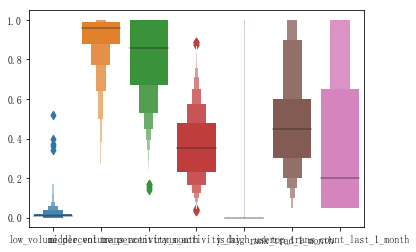

In [95]:
sns.boxenplot(data=numpercent_tr_te)

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


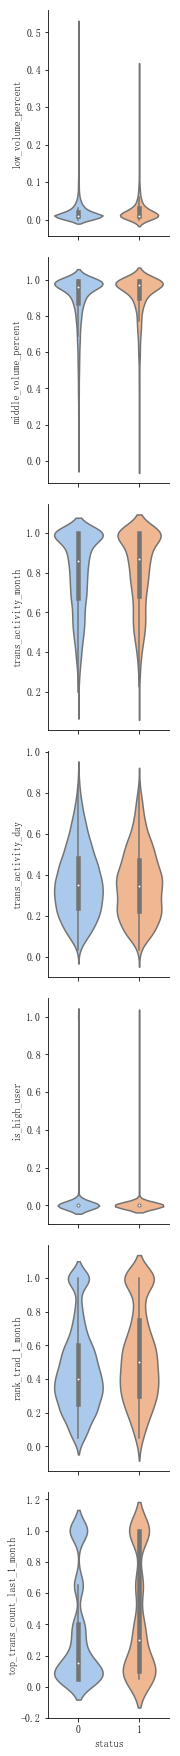

In [96]:
g = sns.PairGrid(pd.concat((numpercent_tr_te, y), axis=1),
                 x_vars=['status'],
                 y_vars=numpercent_tr_te.columns,
                 aspect=.75, height=3.5)
g.map(sns.violinplot, palette="pastel")

两个 label 下，数值分布基本是一致的。  
把小数用二值化表示，防止过拟合

In [97]:
bins=[0.02, 0.95, 0.9, 0.3, 0.4, 0.15, 0.5]

In [98]:
for i, v in enumerate(numpercent_tr_te.columns):
    numpercent_tr_te[v] = np.where(numpercent_tr_te[v]>bins[i], 1, 0)

In [99]:
train_test[numpercent_tr_te.columns] = numpercent_tr_te

### 处理整数

从与 status 最相关的几个特征入手

#### trans_fail_top_count_enum_last_1_month

主要处理思路分箱计数，违约率排名

In [100]:
train_test['trans_fail_top_count_enum_sum'] = train_test['trans_fail_top_count_enum_last_1_month'] + \
    train_test['trans_fail_top_count_enum_last_6_month'] + \
    train_test['trans_fail_top_count_enum_last_12_month']

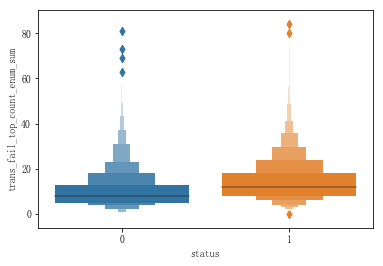

In [101]:
sns.boxenplot(data=pd.concat(
    (train_test['trans_fail_top_count_enum_sum'], y), axis=1), y='trans_fail_top_count_enum_sum', x='status')

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


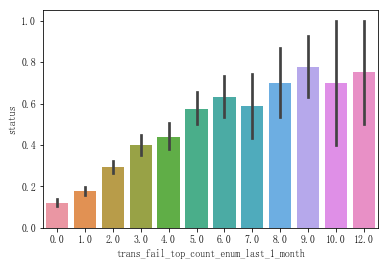

In [102]:
sns.barplot(data=pd.concat((train_test, y), axis=1), y='status', x='trans_fail_top_count_enum_last_1_month')

In [103]:
# 类别违约排名
def cat_rank(train_test, train_set, col):
    df_rank = train_set.groupby(col)['status'].mean().reset_index()
    df_rank[col + '_rank'] = df_rank['status'].rank()
    df_rank.drop('status', axis=1, inplace=True)
    train_test = pd.merge(train_test, df_rank, on=col, how='left')
    return train_test

# 类别违约率
def cat_ratio(train_test, train_set, col):
    df_ratio = train_set.groupby(col)['status'].mean().reset_index()
    df_ratio[col + '_ratio'] = df_ratio['status']
    df_ratio.drop('status', axis=1, inplace=True)
    train_test = pd.merge(train_test, df_ratio, on=col, how='left')
    return train_test

In [104]:
# 类别分箱及统计
def cat_bins_count(train_test, col, bins):
    train_test[col+'_bins'] = pd.cut(train_test[col], bins=bins, right=False, labels=[str(i) for i in bins][1:])
    train_test[col+'_bincount'] = train_test.groupby(col+'_bins')[col].transform('count')

In [105]:
bins=[0, 10, 20, 30, 40, 60, 100, 500]

In [106]:
cat_bins_count(train_test, 'trans_fail_top_count_enum_sum', bins)

In [107]:
train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'trans_fail_top_count_enum_sum_bins')

#### history_fail_fee

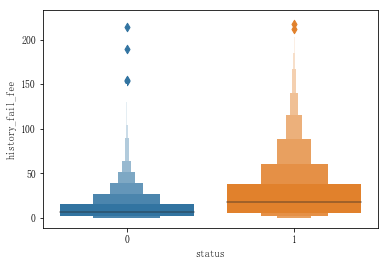

In [108]:
sns.boxenplot(data=pd.concat((train_test, y), axis=1), x='status', y='history_fail_fee')

In [109]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['history_fail_fee']>100]['status'].mean()

0.7466666666666667

In [110]:
bins = list(range(0, 100, 10)) + [500]

对 history_fail_fee 进行分箱，统计每个箱子内的个数及违约率排名

In [111]:
cat_bins_count(train_test, 'history_fail_fee', bins)

train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'history_fail_fee_bins')

#### loans_overdue_count

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


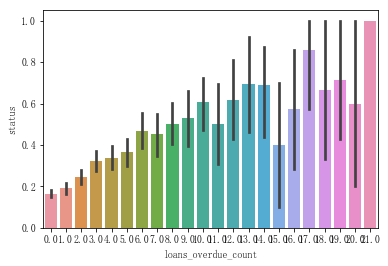

In [112]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='loans_overdue_count', y='status')

In [113]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['loans_overdue_count']>8]['status'].mean()

0.5919282511210763

In [114]:
bins = list(range(0, 11)) + [30]

In [115]:
cat_bins_count(train_test, 'loans_overdue_count', bins)

train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1), 'loans_overdue_count_bins')

#### latest_one_month_fail

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


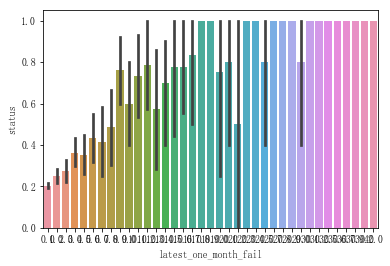

In [116]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='latest_one_month_fail', y='status')

In [117]:
pd.concat((train_test, y), axis=1)[pd.concat((train_test, y), axis=1)['latest_one_month_fail']>6]['status'].mean()

0.7259615384615384

In [118]:
bins = list(range(0, 14)) + [100]

In [119]:
cat_bins_count(train_test, 'latest_one_month_fail', bins)

train_test = cat_rank(train_test, pd.concat(
    (train_test, y), axis=1), 'latest_one_month_fail_bins')

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


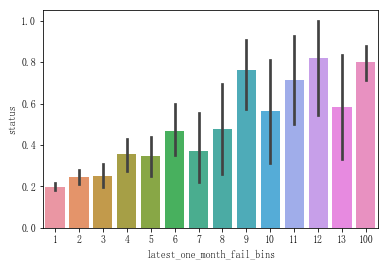

In [120]:
sns.barplot(data=pd.concat(
    (train_test[:x_train.shape[0]], y), axis=1), x='latest_one_month_fail_bins', y='status')

#### loans_score

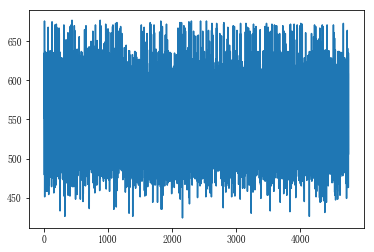

In [121]:
plt.plot(train_test['loans_score'])

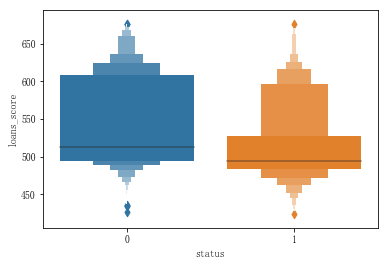

In [122]:
sns.boxenplot(data=pd.concat((train_test['loans_score'], y), axis=1), y='loans_score', x='status')

In [123]:
bins = list(range(400, 750, 50))

In [124]:
cat_bins_count(train_test, 'loans_score', bins)

In [125]:
train_test = cat_rank(train_test, pd.concat((train_test, y), axis=1)[
                      :x_train.shape[0]], 'loans_score_bins')

In [126]:
dataset05 = train_test
dataset05 = dataset05.convert_objects(convert_numeric=True)
dataset05 = minmax_scale(dataset05)
x_train, x_test, y_train, y_test = train_test_split(dataset05, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.80      0.97      0.88      2863
          1       0.76      0.27      0.39       940

avg / total       0.79      0.80      0.76      3803

SVC AUC：
 0.8082720847793937
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.78      0.97      0.86       698
          1       0.73      0.25      0.38       253

avg / total       0.77      0.78      0.73       951

SVC AUC：
 0.794330498204922


# 交叉特征

## 高相关或低相关的统计量

In [127]:
corrs = pd.concat((train_test, y), axis=1).corr().loc['status'].sort_values(ascending=False)

所有 rank 的平均数，最大值
bool 特征的加和

rank 的平均数/最大值

In [128]:
ranks = ['trans_fail_top_count_enum_sum_bins_rank', 'history_fail_fee_bins_rank',
         'loans_overdue_count_bins_rank', 'latest_one_month_fail_bins_rank', 'loans_score_bins_rank']

In [129]:
train_test['corr_rank_sum'] = train_test[ranks].sum(1)
train_test['corr_rank_max'] = train_test[ranks].max(1)

C:\Users\hotheat\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


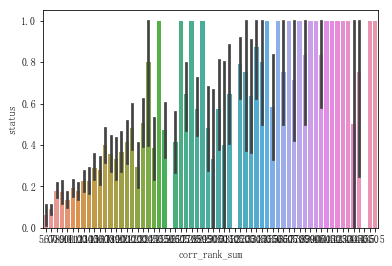

In [130]:
sns.barplot(data=pd.concat((train_test, y), axis=1), x='corr_rank_sum', y='status')

In [131]:
bincounts = ['latest_one_month_fail_bincount', 'loans_overdue_count_bincount',
            'history_fail_fee_bincount', 'trans_fail_top_count_enum_sum_bincount']

In [132]:
train_test['bin_counts_sum'] = train_test[bincounts].sum(1)

## 高相关的交叉特征

In [133]:
corr_mat = pd.concat((train_test, y)[:x_train.shape[0]], axis=1).corr()

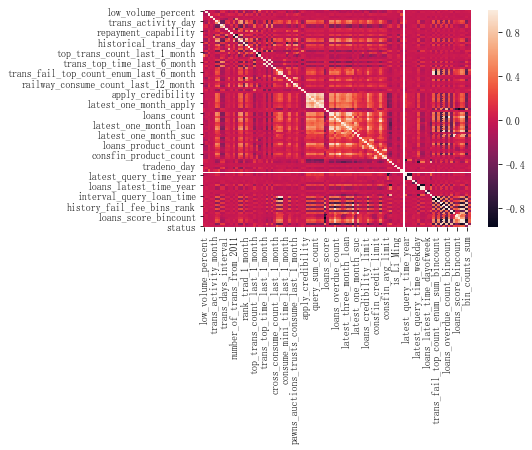

In [134]:
sns.heatmap(corr_mat)

相关系数 >0.85 的特征

In [135]:
high_corrs = []
for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]):
        if corr_mat.values[i][j] >0.85 or corr_mat.values[i][j] <-0.85:
            if i != j:
                high_corrs.append((corr_mat.index[i], corr_mat.columns[j]))

In [136]:
def scatter_corr2(idx, ax):
    c1, c2 = high_corrs[idx]
    sns.scatterplot(data=pd.concat((train_test[:x_train.shape[0]], y), axis=1), x=c1, y=c2, ax=ax, hue='status')

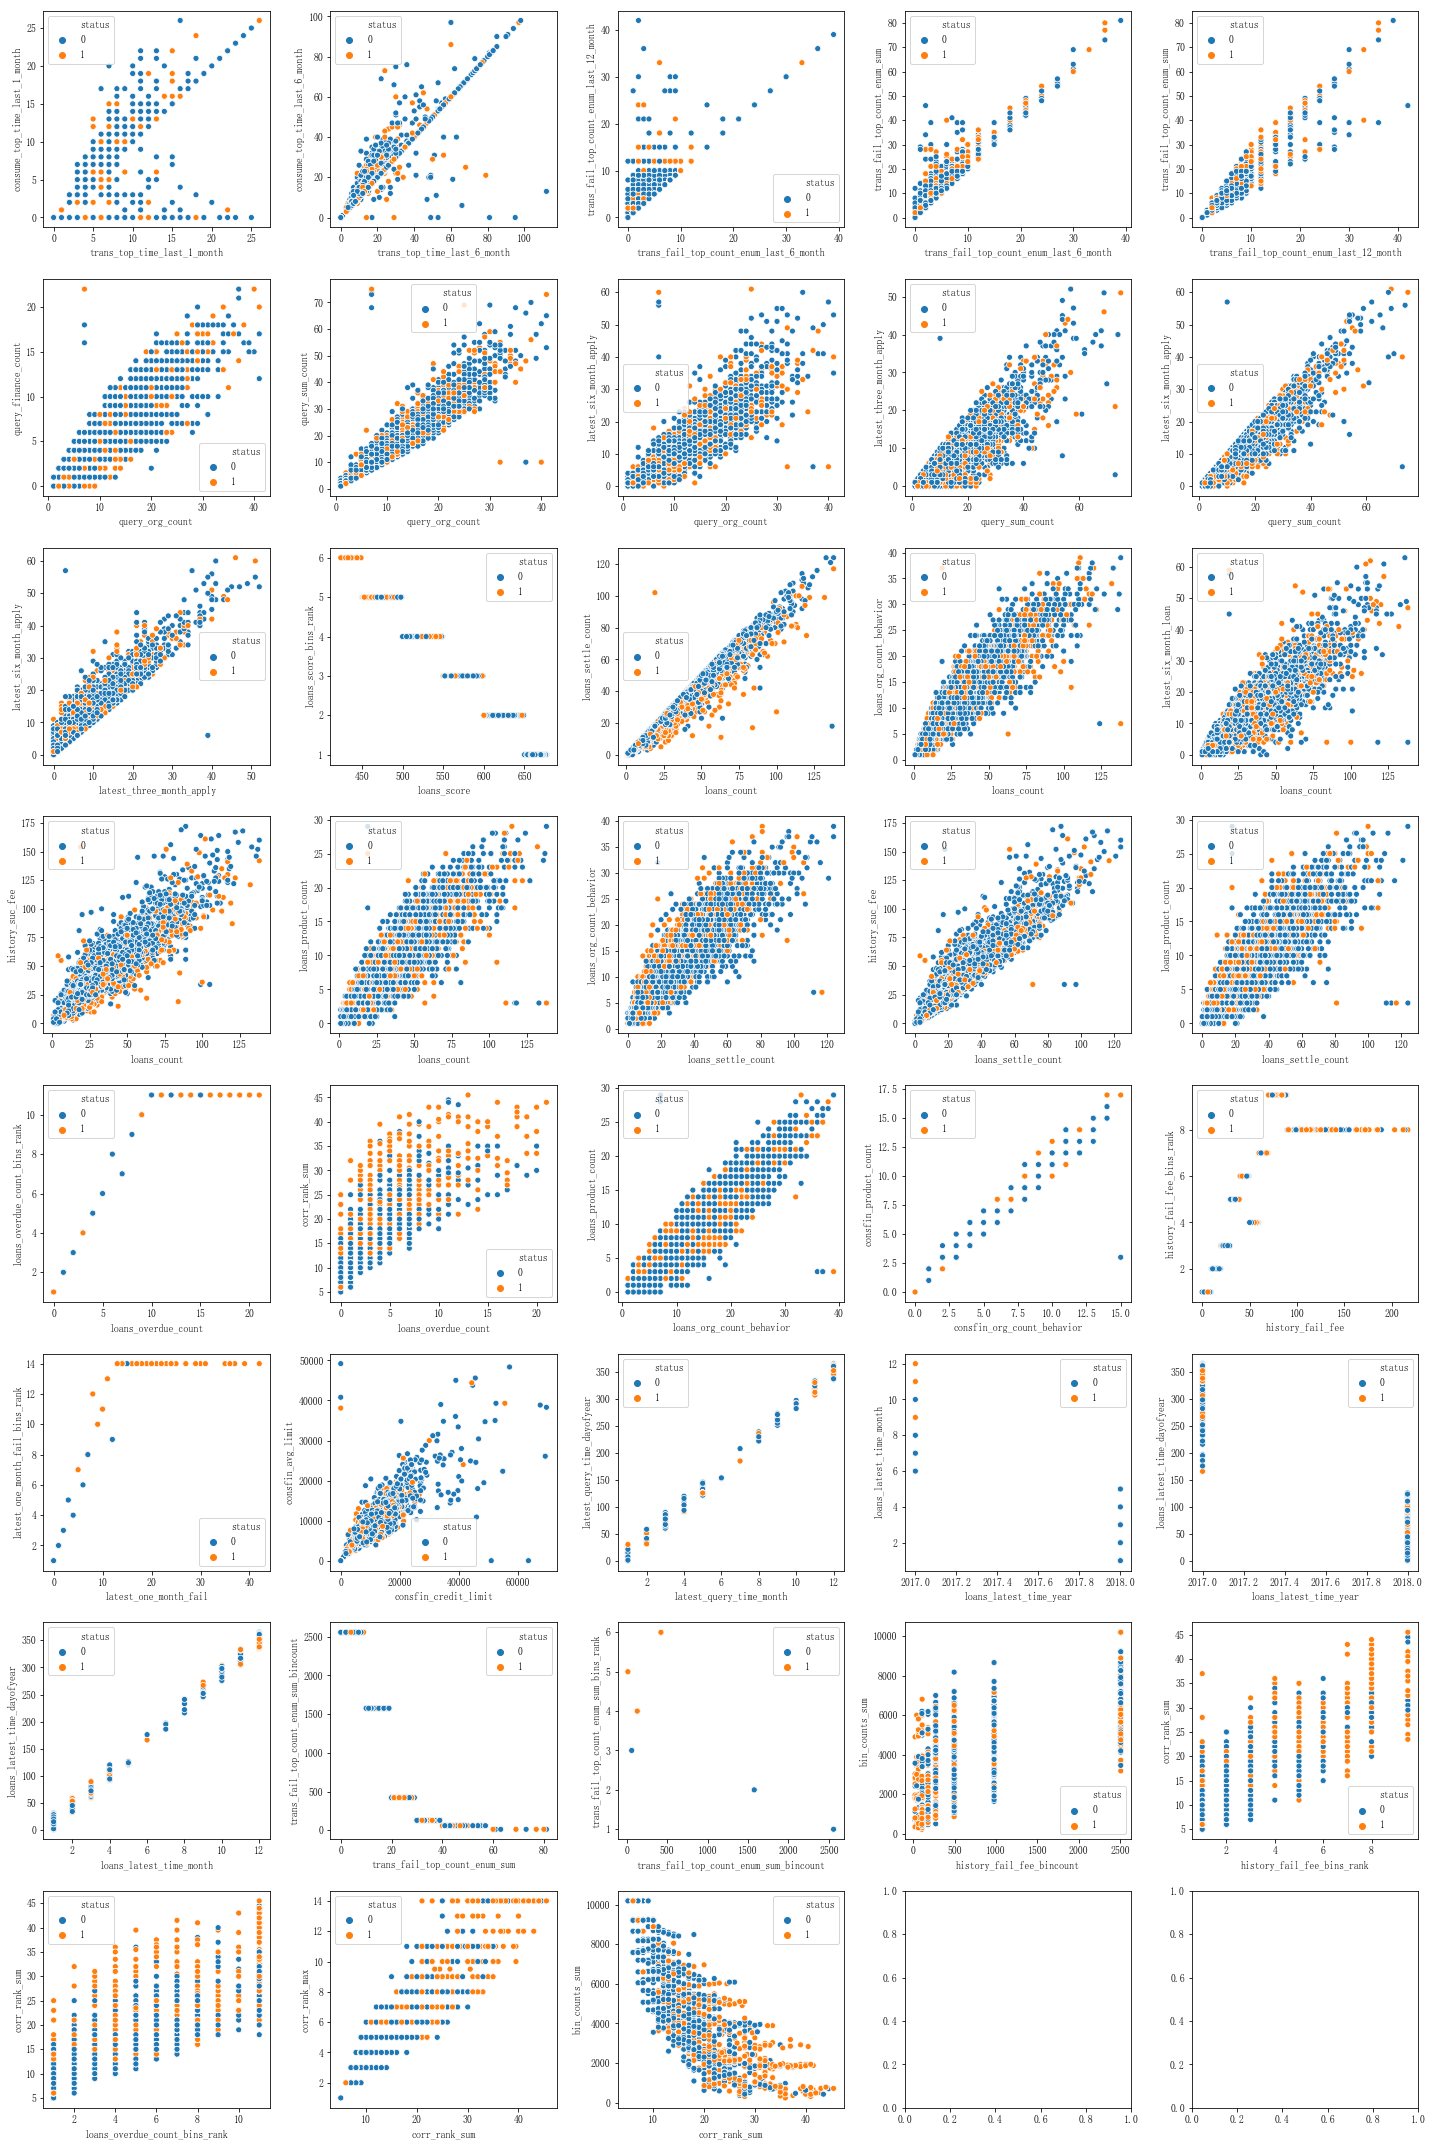

In [137]:
fig, axes = plt.subplots(8, 5, figsize=(20, 30))
axes = [j for i in axes for j in i]
for i in range(len(high_corrs)):
    scatter_corr2(i, axes[i])
plt.tight_layout()

找出 label = 1 和 0 中分布不一致的做交叉

In [138]:
cross_feat = ['trans_top_time_last_6_month+consume_top_time_last_6_month', 'trans_fail_top_count_enum_last_12_month+trans_fail_top_count_enum_last_6_month',
              'loans_settle_count/loans_count', 'history_suc_fee/loans_count', 'loans_org_count_behavior/loans_settle_count', 'loans_credit_limit+loans_avg_limit',
             'loans_overdue_count_bins/loans_overdue_count', 'loans_overdue_count_bins_rank/loans_overdue_count', 
             'latest_one_month_fail/latest_one_month_fail_bins']

In [139]:
for i in cross_feat:
    if '/' in i:
        f1, f2 = i.split('/')
        train_test[i] = train_test[f1].values.astype(
            'float') / (train_test[f2].values.astype('float')+0.001)
    elif '+' in i:
        f1, f2 = i.split('+')
        train_test[i] = train_test[f1] + train_test[f2]

In [140]:
dataset06 = train_test
dataset06 = dataset06.convert_objects(convert_numeric=True)
dataset06 = minmax_scale(dataset06)
x_train, x_test, y_train, y_test = train_test_split(dataset06, y, test_size=0.2, random_state=666)
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train, y_train, x_test)

C:\Users\hotheat\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


----Training Report----
SVC report：
              precision    recall  f1-score   support

          0       0.80      0.97      0.88      2863
          1       0.77      0.27      0.40       940

avg / total       0.79      0.80      0.76      3803

SVC AUC：
 0.8090037232184659
----Test Report----
SVC report：
              precision    recall  f1-score   support

          0       0.78      0.96      0.86       698
          1       0.72      0.25      0.37       253

avg / total       0.76      0.77      0.73       951

SVC AUC：
 0.7940133866382777


In [141]:
lgbmClassifier = LGBMClassifier()
svcmodel = SklearnWrapper(lgbmClassifier)
print_result(svcmodel, x_train, y_train, x_test)

----Training Report----
LGBMClassifier report：
              precision    recall  f1-score   support

          0       0.99      1.00      1.00      2863
          1       1.00      0.97      0.98       940

avg / total       0.99      0.99      0.99      3803

LGBMClassifier AUC：
 0.9998454232652849
----Test Report----
LGBMClassifier report：
              precision    recall  f1-score   support

          0       0.80      0.93      0.86       698
          1       0.65      0.37      0.47       253

avg / total       0.76      0.78      0.76       951

LGBMClassifier AUC：
 0.7879033262738259


C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# 特征选择

特征选择的方法有多种
- 基于先验知识的特征筛选方式
    - 缺失比例
    - 特征方差
    - 特征相关性
    - 特征可解释性
- 基于模型打分的特征筛选方式
    - Permutation Importance
    - Partial Dependence Plots
    - SHAP Values
    - Null Importance  
    参考 https://zhuanlan.zhihu.com/p/45898896  
         https://www.kaggle.com/ogrellier/feature-selection-with-null-importances
- 其他方法
    - 利用 IV 值进行特征选择
    - 利用 XGB，LGB 或 RF 进行特征选择
 

## 基于模型打分的方式

### Permuation Importance

排列重要性，一定是在 model 训练完成后，才可以计算的。简单来说，就是改变数据表格中某一列的数据的排列，看其对预测准确性的影响有多大。大概三个步骤：
- 训练好模型
- 拿某一个 feature column, 然后随机打乱顺序。然后用模型来重新预测一遍，看看自己的 metric 或者 loss function 变化了多少
- 把上一个步骤中打乱的 column 复原，换下一个 column 重复上一个步骤，直到所有 column 都算一遍

In [142]:
from sklearn.ensemble import RandomForestClassifier
my_model = RandomForestClassifier(random_state=0).fit(x_train, y_train)
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(my_model, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = train_test.columns.tolist())

C:\Users\hotheat\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Weight,Feature
0.0063 ± 0.0059,corr_rank_max
0.0063 ± 0.0052,loans_overdue_count_bins_rank
0.0061 ± 0.0043,consfin_avg_limit
0.0046 ± 0.0029,latest_one_month_fail_bins
0.0038 ± 0.0029,loans_settle_count
0.0034 ± 0.0028,trans_fail_top_count_enum_last_12_month
0.0032 ± 0.0038,history_fail_fee_bins_rank
0.0029 ± 0.0031,latest_three_month_loan
0.0029 ± 0.0025,historical_trans_amount
0.0029 ± 0.0031,latest_one_month_fail_bins_rank


### partial dependence

告诉你一个特征是如何影响预测的。通过对某个变量反复的进行修改和重新预测，观察预测结果。

In [143]:
feature_names = [i for i in train_test.columns if train_test[i].dtype in [np.float, np.int64]]
feature_to_plot = 'loans_avg_limit'

In [144]:
X = train_test[feature_names]

In [145]:
train_X_true, test_X_true, train_y_true, test_y_true = train_test_split(
    X, y, random_state=1)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13e5d61ab38>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x13e5d61d2e8>})

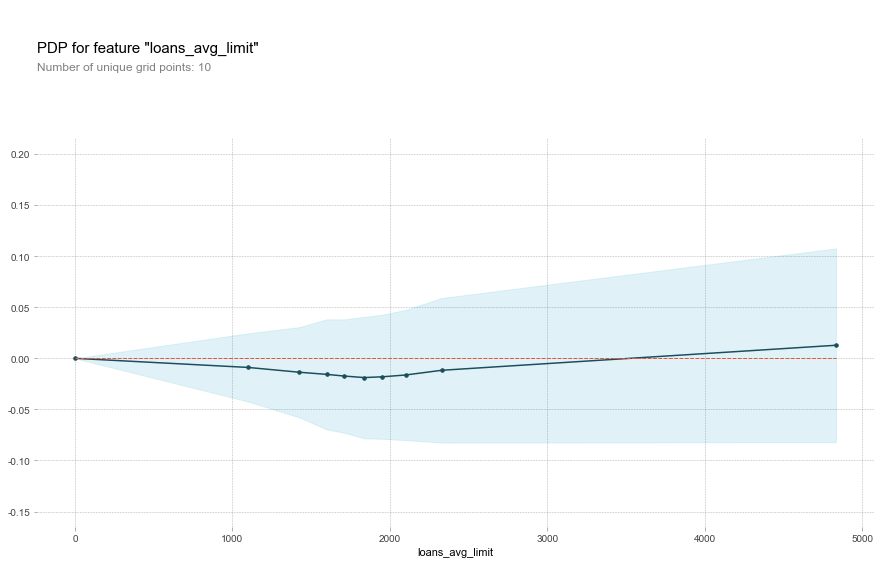

In [146]:
# Build Random Forest model
from pdpbox import pdp, get_dataset, info_plots
rf_model = RandomForestClassifier(random_state=0).fit(train_X_true, train_y_true)
pdp_dist = pdp.pdp_isolate(model=rf_model, dataset=test_X_true, model_features=feature_names, feature=feature_to_plot)
pdp.pdp_plot(pdp_dist, feature_to_plot)

### SHAP value

利用 SHAP value 生成的 Summary plot
- 竖直坐标是说明它属于哪个特征
- 颜色代表了这个特征在某一行数据里的数值是高还是低
- 水平位置代表了这个特征在某一行数据里是提高预测值还是降低预测值

In [147]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [148]:
import shap  # package used to calculate Shap values
# Create object that can calculate shap values
explainer = shap.TreeExplainer(my_model)
# calculate shap values. This is what we will plot.
# Calculate shap_values for all of val_X rather than a single row, to have more data for plot.
shap_values = explainer.shap_values(val_X)

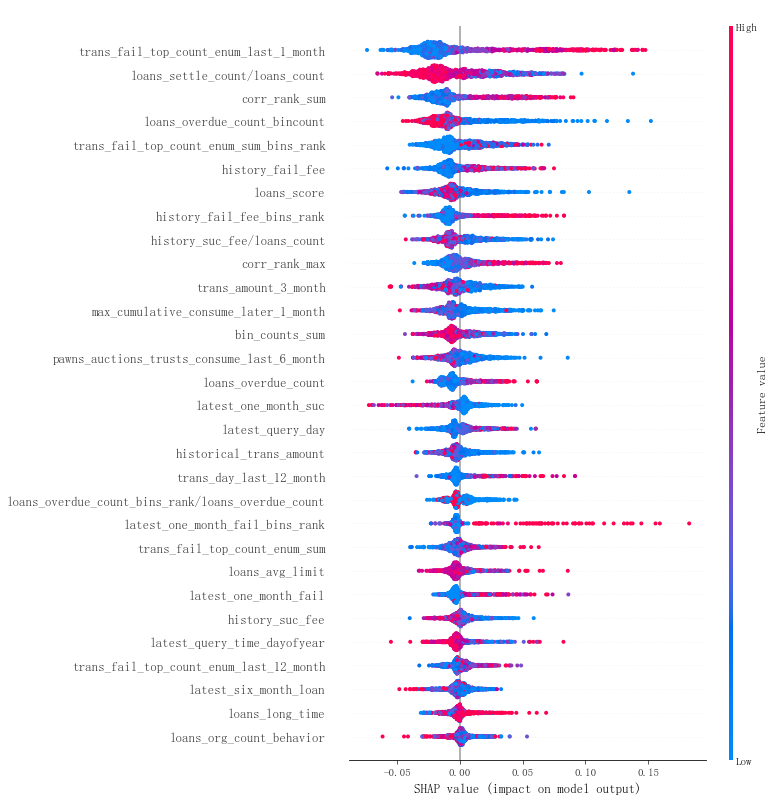

In [149]:
shap.initjs()
# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values[1], val_X, max_display=30)

根据 SHAP value 选出的

### Null Importance

将特征分数与随机假特征的分数（即Null Importance）进行对比，假如特征的分数并不能明显超过null importance，那么证明这个特征是一个无用的特征。

#### 得分标准
采用 lgb 中的 rf 里的基尼增益，分裂次数和 AUC score 作为评价指标

In [150]:
import lightgbm as lgb
def get_feature_importances(data, shuffle, seed=None):
    # Gather real features
    train_features = [i for i in data.columns if not i in ['status']]
    # Go over fold and keep track of CV score (train and valid) and feature importances

    # Shuffle target if required
    y = data['status'].copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = data['status'].copy().sample(frac=1.0)

    # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
    dtrain = lgb.Dataset(data[train_features], y,
                         free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 8,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': 4
    }

    # Fit the model
    clf = lgb.train(params=lgb_params, train_set=dtrain,
                    num_boost_round=200)

    # Get feature importances
    imp_df = pd.DataFrame()
    imp_df["feature"] = train_features
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(
        importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))

    return imp_df

In [151]:
# Get the actual importance, i.e. without shuffling
data = pd.concat((train_test, y), axis=1)
actual_imp_df = get_feature_importances(data=data, shuffle=False)

In [152]:
actual_imp_df.sort_values(by='importance_gain', ascending=False).head()

,feature,importance_gain,importance_split,trn_score
107,corr_rank_sum,6973.916859,411,0.91256
29,trans_fail_top_count_enum_last_1_month,4925.195018,591,0.91256
112,loans_settle_count/loans_count,3707.153284,463,0.91256
17,trans_amount_3_month,1293.130029,401,0.91256
48,loans_score,1247.705554,439,0.91256


#### Build Null Importances distribution

In [153]:
null_imp_df = pd.DataFrame()
nb_runs = 80
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=data, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with   80 of   80 (Spent   1.6 min)

In [154]:
import matplotlib.gridspec as gridspec
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

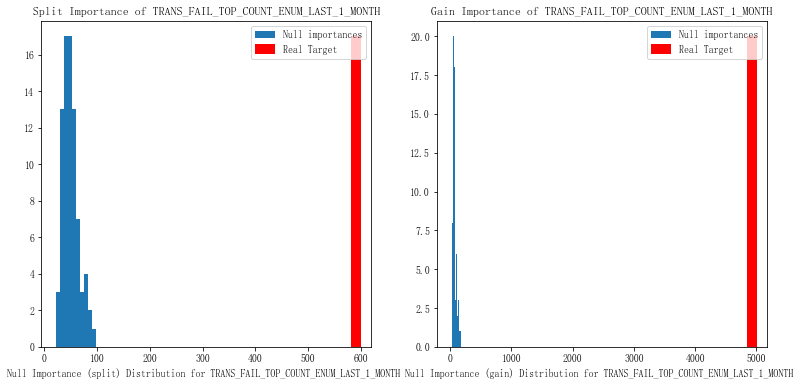

In [155]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='trans_fail_top_count_enum_last_1_month')

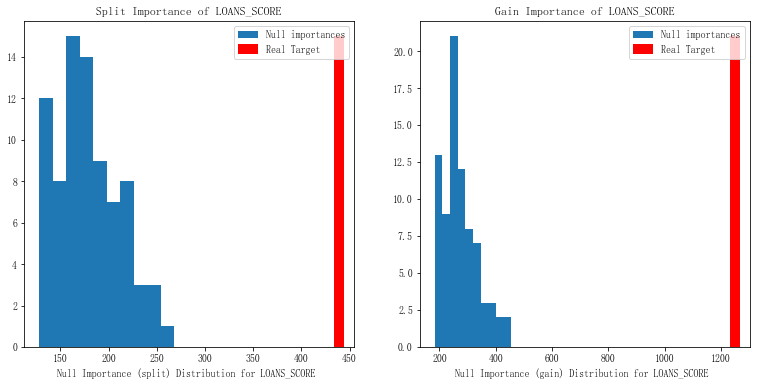

In [156]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='loans_score')

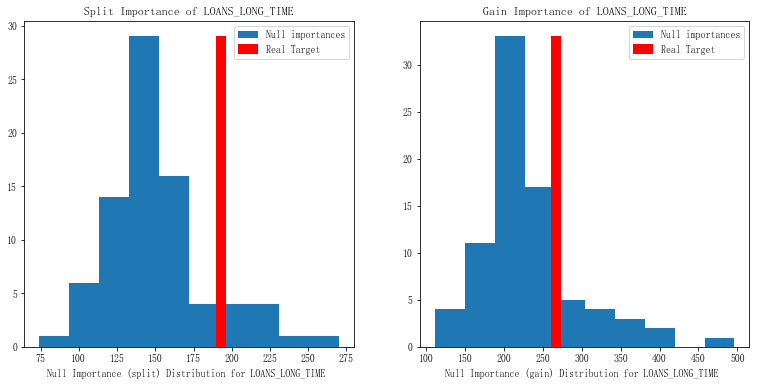

In [157]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='loans_long_time')

上面三个特征是根据 SHAP value 选出的排名 1，7，29 的特征，可以看出排名第 29 的特征，效果已经开始接近 null importance 的分布了

#### 如何对特征进行打分

可以计算在 actual importance 中距 null importance 的距离，actual/null max, actual/null mean, actual mean/null max 等。这里用了一个公式

$$
gain score = log(\frac{1e^{-10} + actual gain}{1 + np.percentile(null gain, 75)}) 
$$

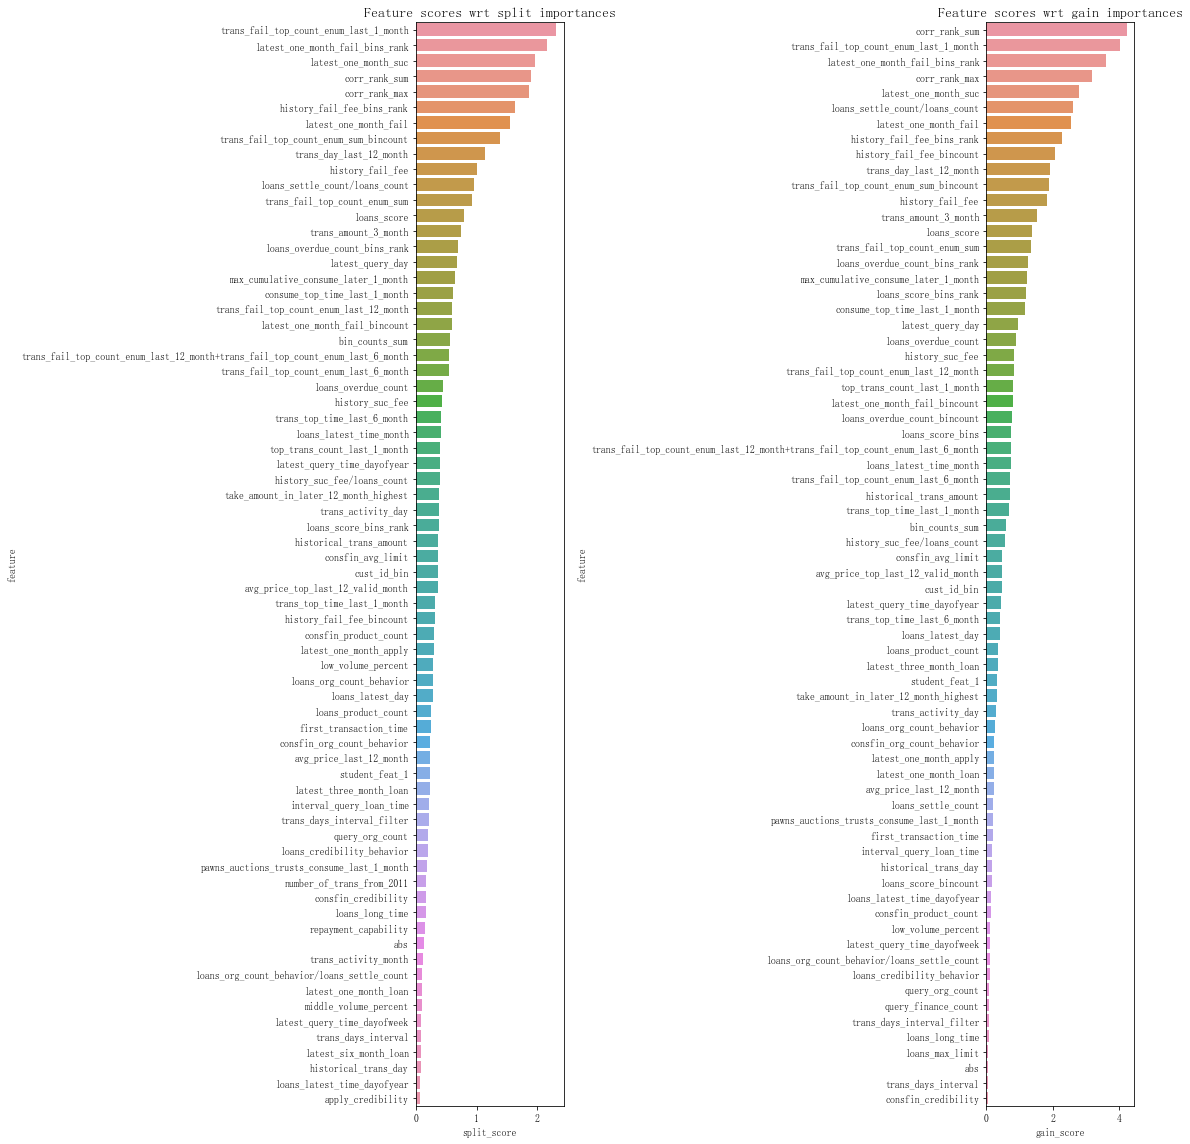

In [158]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

In [159]:
null_imp_df.to_csv('null_importances_distribution_rf.csv')
actual_imp_df.to_csv('actual_importances_ditribution_rf.csv')

#### Check the impact of removing uncorrelated features

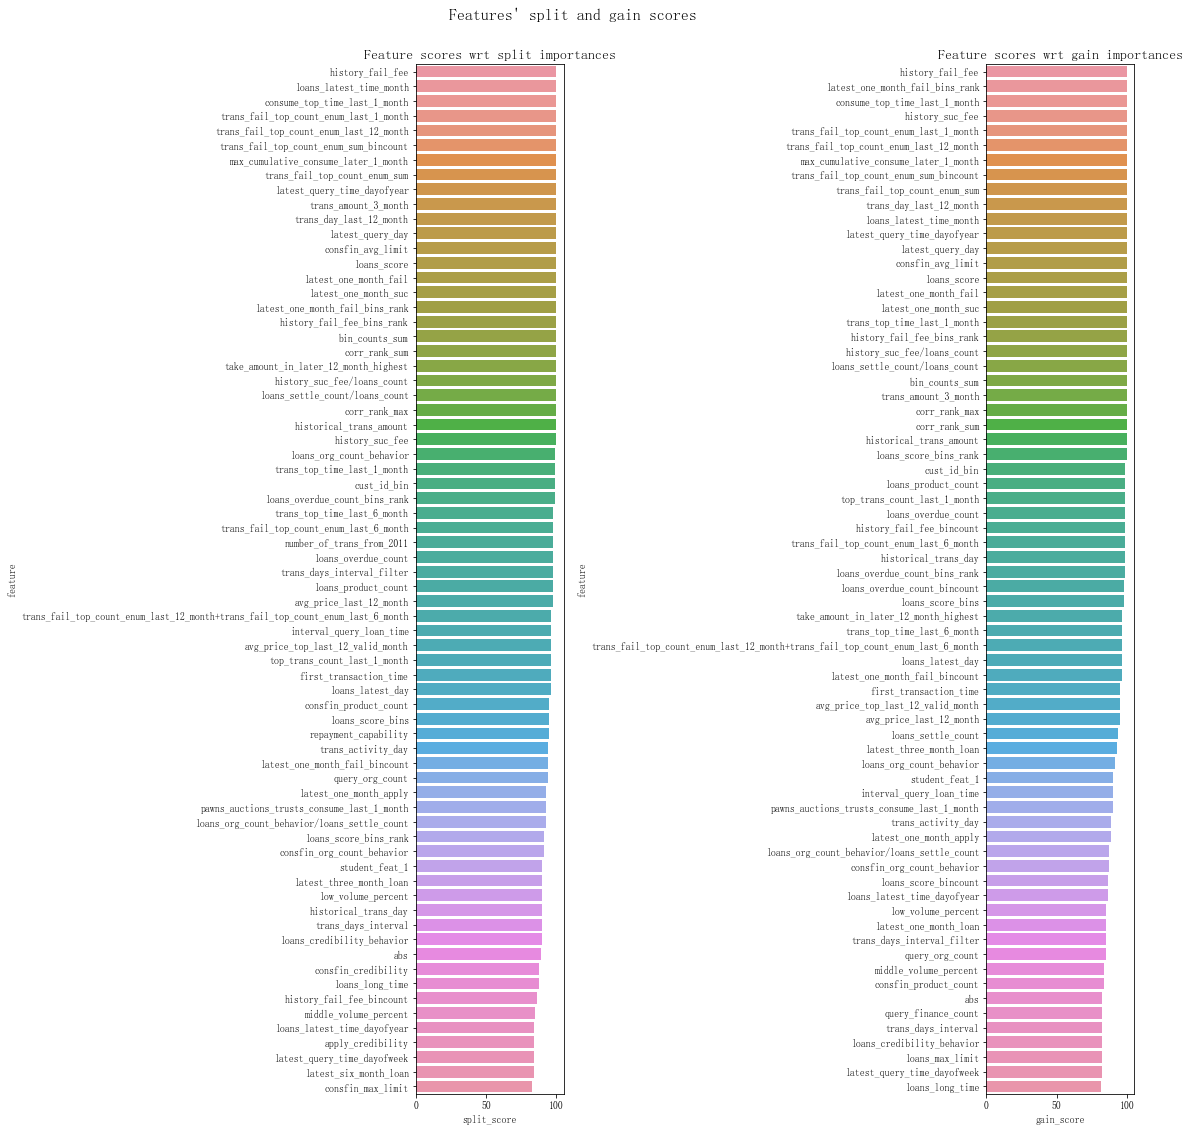

In [160]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

#### Score feature removal for different thresholds

In [179]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM
    dtrain = lgb.Dataset(df[train_features], target,
                         free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': 4,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }

    # Fit the model
    hist = lgb.cv(
        params=lgb_params,
        train_set=dtrain,
        num_boost_round=2000,
        categorical_feature=cat_feats,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    # Return the last mean / std values
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]

# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])


data = data.astype('float')
categorical_feats = train_test.columns.tolist()
for threshold in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]:
    split_feats = [_f for _f, _score,
                   _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (
        _score >= threshold) & (_f in categorical_feats)]
    gain_feats = [_f for _f, _,
                  _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (
        _score >= threshold) & (_f in categorical_feats)]

    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(
        df=data, train_features=split_feats, cat_feats=split_cat_feats, target=data['status'])
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(
        df=data, train_features=gain_feats, cat_feats=gain_cat_feats, target=data['status'])
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.754234 +/- 0.013526
	 GAIN  : 0.754234 +/- 0.013526
Results for threshold  10
	 SPLIT : 0.751575 +/- 0.017676
	 GAIN  : 0.750660 +/- 0.013073
Results for threshold  20
	 SPLIT : 0.752826 +/- 0.013527
	 GAIN  : 0.752688 +/- 0.009810
Results for threshold  30
	 SPLIT : 0.753688 +/- 0.013757
	 GAIN  : 0.753767 +/- 0.014980
Results for threshold  40
	 SPLIT : 0.752379 +/- 0.015640
	 GAIN  : 0.750047 +/- 0.004747
Results for threshold  50
	 SPLIT : 0.752913 +/- 0.009938
	 GAIN  : 0.749416 +/- 0.012375
Results for threshold  60
	 SPLIT : 0.754184 +/- 0.014825
	 GAIN  : 0.755679 +/- 0.015281
Results for threshold  70
	 SPLIT : 0.756070 +/- 0.013956
	 GAIN  : 0.752761 +/- 0.007894
Results for threshold  80
	 SPLIT : 0.750778 +/- 0.018144
	 GAIN  : 0.749611 +/- 0.013409
Results for threshold  90
	 SPLIT : 0.755712 +/- 0.013895
	 GAIN  : 0.756839 +/- 0.015395
Results for threshold  95
	 SPLIT : 0.757666 +/- 0.010258
	 GAIN  : 0.759352 +/- 0.018451
Results fo

## 利用 XGB 进行模型选择

利用 xgb 选择特征时，可以从
- 特征 Gini 增益
- 特征分裂次数
- 特征所在的平均深度
- 特征是否被使用
- 特征子节点样本数量
等方面考虑。  
利用 xgbfir 可以直接计算特征重要性的属性值，一般不考虑 rank 值，从 gini 系数和特征分裂次数等方面考虑。  
能够更好的看出特征间的交互情况。

In [ ]:
import xgboost as xgb
xgb_cmodel = xgb.XGBClassifier().fit(train_test.astype('float'), y)

In [ ]:
xgbfir.saveXgbFI(xgb_cmodel, feature_names=train_test.columns, OutputXlsxFile='特征重要性.xlsx')

In [ ]:
fi = pd.read_excel('特征重要性.xlsx')

In [ ]:
fi.head()

# 特征选择

先根据 Null importance 选择出前 40 个特征，如果效果不理想，再加特征

In [ ]:
select_features = scores_df.sort_values('gain_score', ascending=False)['feature'].iloc[0:40]

In [ ]:
select_train_test = train_test[select_features]
x_train, x_test, y_train, y_test = train_test_split(select_train_test, y, test_size=0.2, random_state=2018)

In [ ]:
xgb_params1 = {
    'eta': 0.01,
    'min_child_weight': 15,
    'max_delta_step': 2,
    'colsample_bytree': 0.75,
    'subsample': 0.75,
    'seed': 234,
    'max_depth': 4,
    'nthread': 6,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    # 'num_class' : 2,
    'silent': 1,
    # 'scale_pos_weight': 4.6796,
}

In [ ]:
xgb_clf = XgbWrapper(params=xgb_params1)
xgb_train, xgb_test = ModelRun().run_oof(xgb_clf, x_train.values, y_train.values, x_test.values)

# 模型预测和评估

In [ ]:
train_test_select.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_test_select, y, test_size=0.2, random_state=2018)

In [ ]:
x_train_scale = minmax_scale(x_train)
x_test_scale = minmax_scale(x_test)

## LR

In [ ]:
log_reg = LogisticRegression()
lr_model = SklearnWrapper(log_reg)
print_result(lr_model, x_train_scale, y_train, x_test_scale)

## 决策树

In [ ]:
dtree = DecisionTreeClassifier(max_depth=6)
dtreemodel = SklearnWrapper(dtree)
print_result(dtreemodel, x_train, y_train, x_test)

## SVC

In [ ]:
LinearSVC = SVC(kernel='linear', probability=True)
svcmodel = SklearnWrapper(LinearSVC)
print_result(svcmodel, x_train_scale, y_train, x_test_scale)

## LightGBM

In [ ]:
lgbmClassifier = LGBMClassifier()
lgbmodel = SklearnWrapper(lgbmClassifier)
print_result(lgbmodel, x_train, y_train, x_test)

## XGBClassifier

In [ ]:
xgbClassifier = XGBClassifier()
xgbmodel = SklearnWrapper(xgbClassifier)
print_result(xgbmodel, x_train, y_train, x_test)

之前 AUC 的计算错误是因为把 y_pred 当作 y_pred_proba 来计算的。  
为什么最后 AUC 没有提高？